In [208]:
import argparse
import os
from kabuki.analyze import gelman_rubin
import pandas
import hddm
import numpy as np

path = '/home/gdholla1/projects/bias/data/hddm_fits'

def get_model(model):
    df = pandas.read_pickle('/home/gdholla1/projects/bias/data/behavior/behavior.pandas')

    # Prepare data
    data = df[['cue_validity', 'rt', 'correct', 'difficulty', 'subj_idx']]
    data['response'] = data['correct']
    data['rt'] = data['rt'] / 1000.
    data = data[(data.rt > .2) & (data.rt < 1.5)]
    data = data[~data.rt.isnull()]
    data['cue_coding'] = data.cue_validity.map({'valid':1, 'neutral':0, 'invalid':-1})

    def z_link_func(x, data=data):
        return 1 / (1 + np.exp(-(x.values.ravel())))

    regs, free_pars = model.split('_')

    if regs == 'drift':
        z_reg = {'model': 'z ~ 0', 'link_func': z_link_func}
        v_reg = {'model': 'v ~ 1 + C(difficulty) + cue_coding', 'link_func': lambda x: x}
    elif regs == 'startpoint':
        z_reg = {'model': 'z ~ 0 + cue_coding', 'link_func': z_link_func}
        v_reg = {'model': 'v ~ 1 + C(difficulty)', 'link_func': lambda x: x}
    elif regs == 'both':
        z_reg = {'model': 'z ~ 0 + cue_coding', 'link_func': z_link_func}
        v_reg = {'model': 'v ~ 1 + C(difficulty) + cue_coding', 'link_func': lambda x: x}

    reg_descr = [z_reg, v_reg]

    if free_pars == 'sv':
        hddm_model = hddm.HDDMRegressor(data, reg_descr, include=('sv'), bias=True, group_only_regressors=False, group_only_nodes=['sv'])
    elif free_pars == 'sz':
        hddm_model = hddm.HDDMRegressor(data, reg_descr, include=('sz'), bias=True, group_only_regressors=False, group_only_nodes=['sz'])
    elif free_pars == 'svsz':
        hddm_model = hddm.HDDMRegressor(data, reg_descr, include=('sv', 'sz'), bias=True, group_only_regressors=False, group_only_nodes=['sv', 'sz'])
    elif free_pars == 'all':
        hddm_model = hddm.HDDMRegressor(data, reg_descr, include=('sv', 'sz', 'st'), bias=True, group_only_regressors=False, group_only_nodes=['sv', 'sz', 'st'])
        
    reg = re.compile('.*/traces_{model}_[0-9]+.pkl'.format(**locals()))
    fns = [fn for fn in glob.glob('/home/gdholla1/projects/bias/data/hddm_fits/traces_{model}_*.pkl'.format(**locals())) if reg.match(fn)]

    hddm_model.load_db(fns[0], db='pickle')

    for fn in fns[1:]:
        traces = pkl.load(open(fn))    
        for node in hddm_model.get_stochastics().node:
            node.trace._trace[0] = np.concatenate([traces[str(node)][0], node.trace[:]])        


    return hddm_model

In [209]:
import glob
import re

import pickle as pkl

In [210]:
model = get_model('both_all')

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Adding these covariates:
['z_cue_coding']
Adding these covariates:
['v_Intercept', 'v_C(difficulty)[T.hard]', 'v_cue_coding']


In [211]:
traces = model.get_traces()
traces.shape

(9000, 129)

In [224]:
traces.columns.tolist()

['a',
 'a_std',
 'a_subj.1',
 'a_subj.10',
 'a_subj.11',
 'a_subj.12',
 'a_subj.13',
 'a_subj.14',
 'a_subj.15',
 'a_subj.16',
 'a_subj.17',
 'a_subj.18',
 'a_subj.19',
 'a_subj.2',
 'a_subj.3',
 'a_subj.4',
 'a_subj.5',
 'a_subj.6',
 'a_subj.7',
 'a_subj.8',
 'a_subj.9',
 'st',
 'sv',
 'sz',
 't',
 't_std',
 't_subj.1',
 't_subj.10',
 't_subj.11',
 't_subj.12',
 't_subj.13',
 't_subj.14',
 't_subj.15',
 't_subj.16',
 't_subj.17',
 't_subj.18',
 't_subj.19',
 't_subj.2',
 't_subj.3',
 't_subj.4',
 't_subj.5',
 't_subj.6',
 't_subj.7',
 't_subj.8',
 't_subj.9',
 'v_C(difficulty)[T.hard]',
 'v_C(difficulty)[T.hard]_std',
 'v_C(difficulty)[T.hard]_subj.1',
 'v_C(difficulty)[T.hard]_subj.10',
 'v_C(difficulty)[T.hard]_subj.11',
 'v_C(difficulty)[T.hard]_subj.12',
 'v_C(difficulty)[T.hard]_subj.13',
 'v_C(difficulty)[T.hard]_subj.14',
 'v_C(difficulty)[T.hard]_subj.15',
 'v_C(difficulty)[T.hard]_subj.16',
 'v_C(difficulty)[T.hard]_subj.17',
 'v_C(difficulty)[T.hard]_subj.18',
 'v_C(difficul

In [228]:
r = []

for i in np.arange(1, 20):
    r.append({'subj_idx':i,
              'z_cue_coding':traces['z_cue_coding_subj.%d' % i].mean(),
              'v_cue_coding':traces['v_cue_coding_subj.%d' % i].mean(),
              'v_difficulty':traces['v_C(difficulty)[T.hard]_subj.%d' % i].mean()})
    
df = pandas.DataFrame(r)

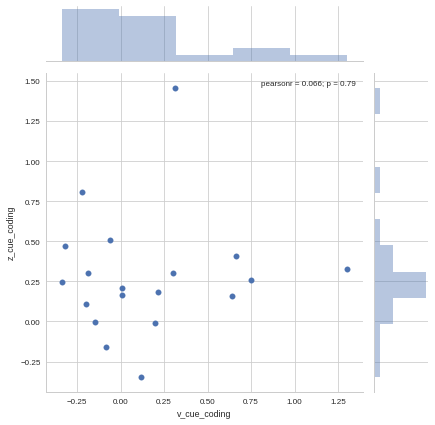

In [229]:
sns.jointplot('v_cue_coding', 'z_cue_coding', df)

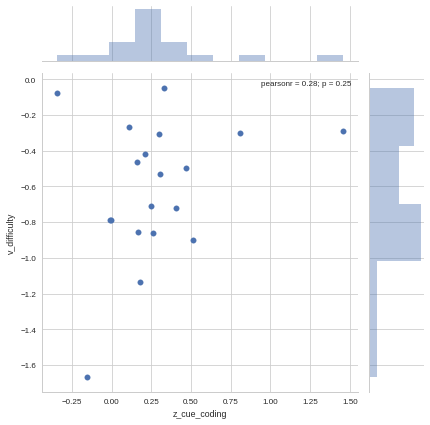

In [230]:
sns.jointplot('z_cue_coding', 'v_difficulty', df)

In [231]:
df.to_pickle('/home/gdholla1/projects/bias/data/derivatives/behavior/hddm/bias_shifts.pkl')